# LocaleDB: Multivariate Time Series Clustering (Mapping)
---

Clustering attempts to suggest patterns in data by grouping similar items together.  This notebook demonstrates plotting results of multivariate time series (MVTS) clustering on a map.  The time series in question are Covid-19 disease dynamics (specifically daily counts of confirmed cases and deaths in US counties).

## Environment
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

from localedb.localedb import LocaleDB
from localedb.clustering import cluster_aff_prop, cluster_kmedoids, dist_mat, plot_ts_clusters_all

db = LocaleDB().set_disease('COVID-19')

First, we declare variables and define convenience functions:

In [3]:
k = 4                           # the number of clusters to request when clustering
dis_dyn = ['n_conf', 'n_dead']  # disease dynamics time series

def get_data(fips='42___', cols=dis_dyn, day0=0, day1=99999, do_interpolate=True, n_diff=0, smooth_window_len=14):
    return np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])

## Pennsylvania
---

We begin by clustering the 67 counties of PA by disease dynamics:

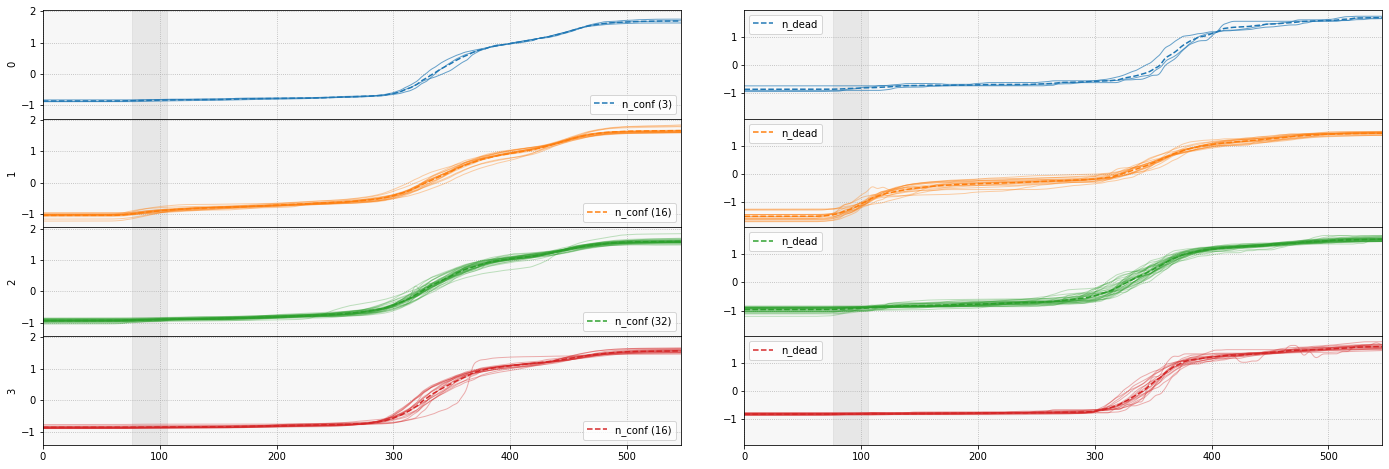

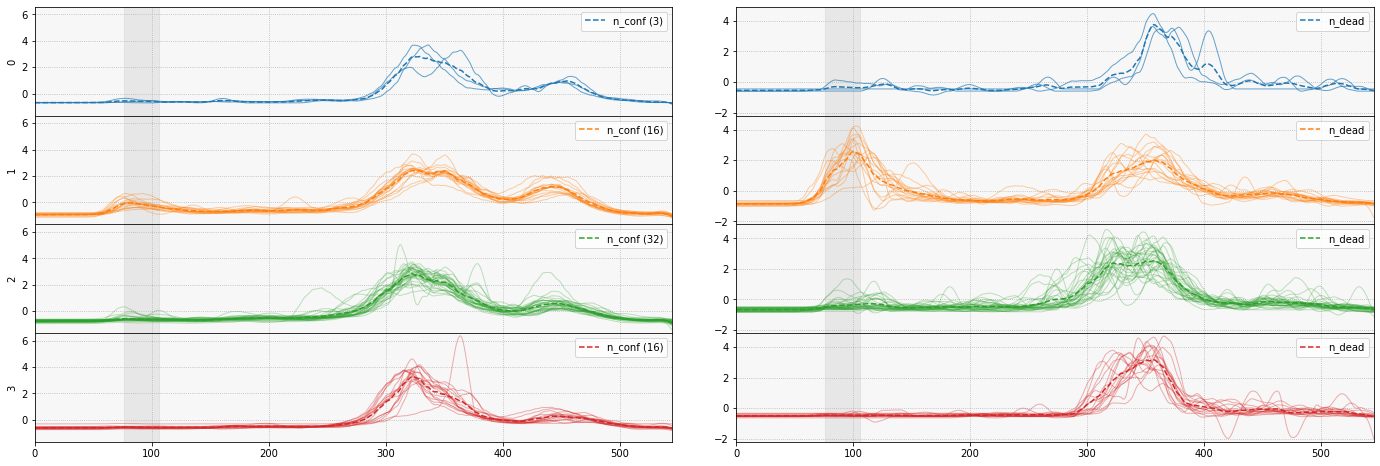

In [4]:
ds_pa   = get_data('42___', n_diff=0, smooth_window_len=14)  # standardized
ds_pa_d = get_data('42___', n_diff=1, smooth_window_len=28)  # standardized differenced

clustering_km = cluster_kmedoids(dist_mat(ds_pa, metric='dtw'), k, metric='precomputed')

_ = plot_ts_clusters_all(ds_pa,   clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])
_ = plot_ts_clusters_all(ds_pa_d, clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])

To visualize these results on a map, we define a function that calls the `LocaleDB().plot_clusters_map()` method.  Because that method requires FIPS codes of the locales being plotted, we pull them from the database as well.

In [5]:
def map_pa(clusters, fips_codes, colors=list(mpl.colors.TABLEAU_COLORS.values()), radius_delta=0, do_large=False):
    if do_large:
        return db.plot_clusters_map(fips_codes, clusters, 0, radius=13 + radius_delta, colors=colors, txt_offset=0.015, location=[40.900000, -77.700000], scroll_wheel_zoom=False, tiles=None, zoom_start=8, height=650)
    return db.plot_clusters_map(fips_codes, clusters, 0, radius=7 + radius_delta, colors=colors, txt_offset=0.025, location=[40.900000, -77.700000], scroll_wheel_zoom=False, tiles=None, zoom_start=7, width=700, height=320)

ds_pa_fips = [r[0] for r in db._exec('SELECT id FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['42___'])]

map_pa(clustering_km.labels_, ds_pa_fips, do_large=False)

## The US
---

Now, we repeat the steps but do that for the 3328 counties of the entire US.

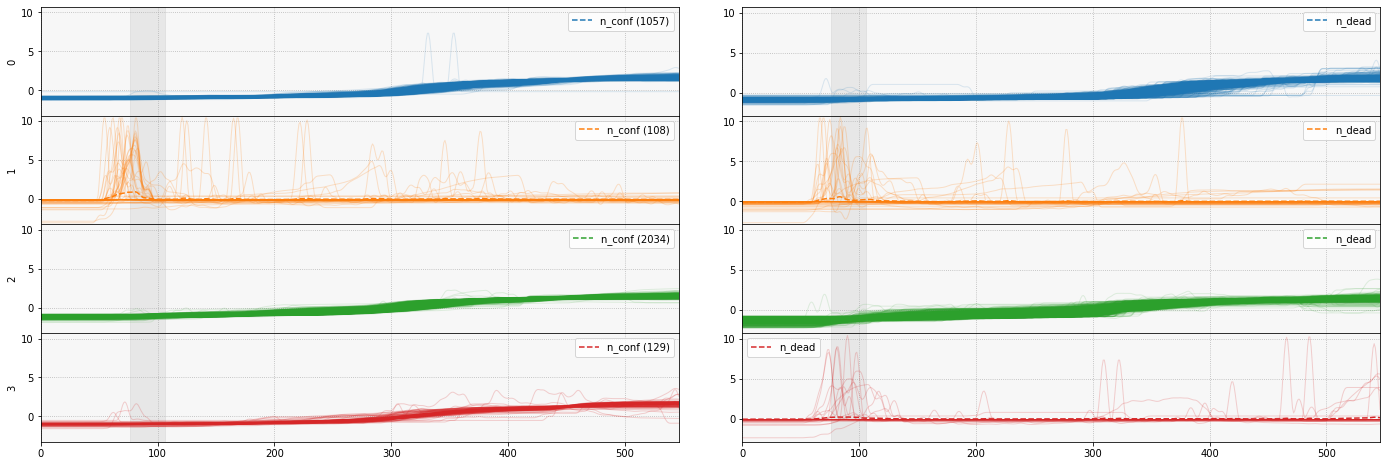

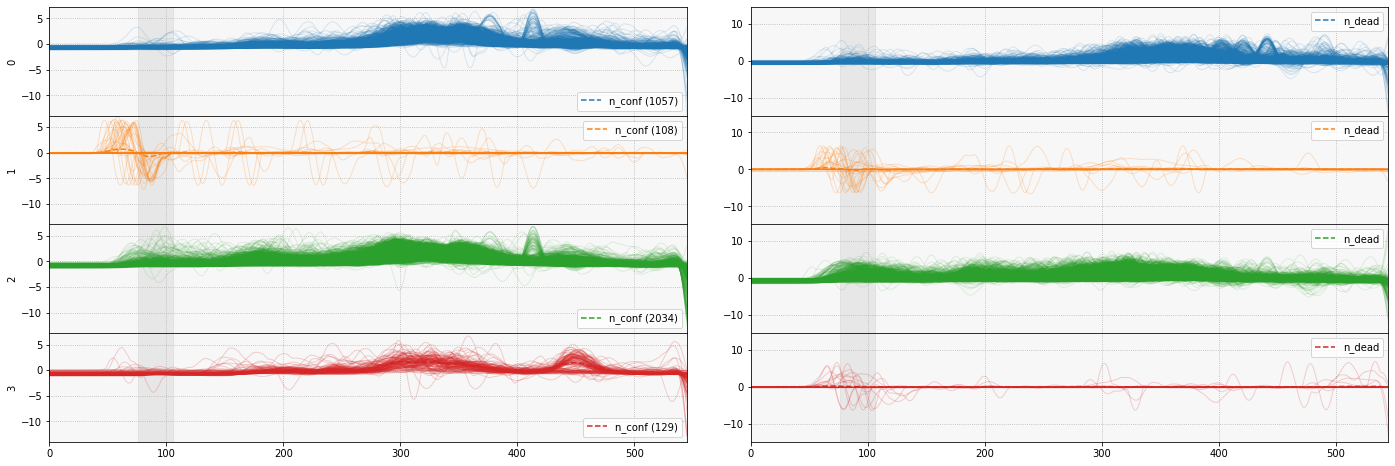

In [6]:
ds_us   = get_data('_____', n_diff=0, smooth_window_len=14)
ds_us_d = get_data('_____', n_diff=1, smooth_window_len=28)

clustering_km = cluster_kmedoids(dist_mat(ds_us, metric='euclidean'), k, metric='precomputed')

_ = plot_ts_clusters_all(ds_us,   clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])
_ = plot_ts_clusters_all(ds_us_d, clustering_km.labels_, 0, dis_dyn, None, True, True, True, True, ':', 12, 2, highlight_rect_xw=[(76,30)])

All that is left to do is to visualize these results on a map (make sure to zoom out or drag the map around to see the two states not shown in the original view, Alaska and Puerto Rico):

In [7]:
def map_us(clusters, fips_codes, colors=list(mpl.colors.TABLEAU_COLORS.values()), radius_delta=0, do_large=False):
    if do_large:
        return db.plot_clusters_map(fips_codes, clusters, 0, radius=4 + radius_delta, colors=colors, txt_fontsize=0.8, txt_offset=0.085, location=[37.500000, -98.5696], scroll_wheel_zoom=False, tiles=None, zoom_start=5, height=800)
    return db.plot_clusters_map(fips_codes, clusters, 0, radius=2 + radius_delta, colors=colors, txt_fontsize=0.6, txt_offset=0.05, location=[37.500000, -98.5696], scroll_wheel_zoom=False, tiles=None, zoom_start=4, width=700, height=400)

ds_us_fips = [r[0] for r in db._exec('SELECT id FROM main.locale WHERE fips LIKE %s ORDER BY fips ASC;', ['_____'])]

map_us(clustering_km.labels_, ds_us_fips, radius_delta=-1, do_large=True)

We finish with a proper cleanup:

In [8]:
del(clustering_km, ds_pa, ds_pa_d, ds_us, ds_us_d, db)